In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [2]:
from string import printable
import re
import os

### Parse and Load data
The raw data contains some non ASCII characters, so we remove these characters, parse the data, and load all the files into a single pandas dataframe keeping only the "Question" attribute

In [3]:
root = "data"
raw_data_path = os.path.join(root, "raw_data")
parsed_data_path = os.path.join(root, "parsed_data") 
processed_data_path = os.path.join(root, "processed_data")   

In [4]:
for txt_file in os.listdir(raw_data_path):
    raw_file_path = os.path.join(raw_data_path, txt_file)
    parsed_file_path = os.path.join(parsed_data_path, txt_file)
    with open(raw_file_path, "r", encoding="utf-8") as f:
        parsed_file = "".join([char for char in f.read() if char in printable])
    with open(parsed_file_path, "w") as f:
        f.write(parsed_file)

#### Show dataset sample

In [4]:
pd.read_table("data/parsed_data/data.txt").head()

,id,Question
0,1,¿Cuáles son los principios fundamentales de la...
1,2,¿Cómo se implementa el polimorfismo en lenguaj...
2,3,¿Cuál es la diferencia entre un algoritmo recu...
3,4,¿Cómo se optimiza el rendimiento de bases de d...
4,5,¿Qué es la arquitectura de microservicios y en...


In [5]:
questions_all = pd.concat([pd.read_table(os.path.join(parsed_data_path, file_name))["Question"] \
 for file_name in os.listdir(parsed_data_path)])

#### Basis Preprocessing
Do some basic preprocessing like dropping null values and duplicates

In [6]:
questions_all.dropna(inplace=True)

In [7]:
questions_all = questions_all.unique()

In [8]:
questions_all[10:15]

array(['¿Cómo se lleva a cabo el análisis y diseño de algoritmos eficientes para resolver problemas complejos?',
       '¿Qué es la ingeniería inversa en el contexto de la seguridad informática?',
       '¿Cuál es la importancia de los contenedores en la implementación de aplicaciones?',
       '¿Cómo se realiza la depuración de código en entornos de desarrollo complejos?',
       '¿Cuáles son las técnicas de protección contra ataques de inyección SQL?'],
      dtype=object)

In [9]:
len(questions_all)

500

#### Preprocessing
remove punctuations, multiple white spaces, tabs, newlines, text between brackets, and null questions

In [10]:
def preprocess_text(question):
    question = question.replace("S08_", "")
    question = question.replace("NOTTTT  FOUND", "")
    question = re.sub("([\(\[]).*?([\)\]])", "", question) # remove text between brackets
    question = re.sub("[^\w\s]", "", question) # remove punctuations
    re.sub("\s+", " ", question) # remove multiple white spaces
    re.sub("[\t\n]", "", question) # remove tabs and newline characters
    question = question.lower().strip()
    return question

In [11]:
questions_processed = [preprocess_text(q) for q in questions_all]
questions_processed = [q for q in questions_processed if len(q) != 0] # remove empty strings after preprocessing

#### Remove long questions
Since we want to emulate a search engine, we ought to remove long sentences and paragraphs

In [12]:
q_lengths = [len(q) for q in questions_processed]

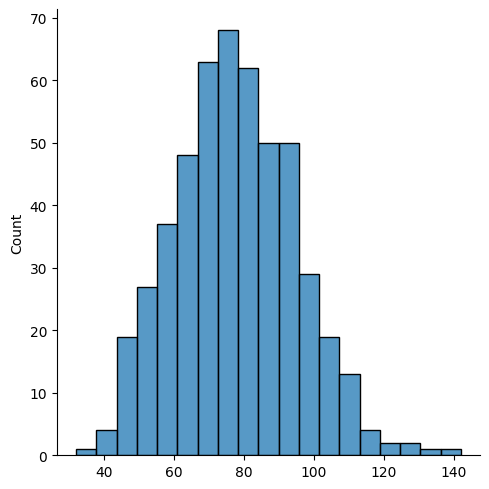

In [13]:
sns.displot(q_lengths)

In [14]:
mean = np.mean(q_lengths)
std = np.std(q_lengths)
print(f"mean: {mean}, std: {std}")

mean: 77.514, std: 17.347213147938202


In [15]:
optimum_length = int(mean + std)
print(f"optimum length: {optimum_length}")

optimum length: 94


In [16]:
questions_short = [q for q in questions_processed if len(q) <= optimum_length]

#### Shuffle Data

In [17]:
import random
random.seed(42)
random.shuffle(questions_short)

In [18]:
questions_short[52:57]

['qué son los métodos mágicos  en python',
 'cuál es la diferencia entre un sistema operativo de 32 bits y uno de 64 bits',
 'qué es chatgpt y en qué se diferencia de otros modelos de lenguaje',
 'qué significan las siglas solid en el contexto del desarrollo de software',
 'cuál es el propósito de la normalización en el diseño de bases de datos']

### Create Dataset and Dataloader
Here we create the vocab, encode questions as char indices, and perform one-hot encoding and padding

In [19]:
class QuestionsDataset(Dataset):
    def __init__(self, questions, vocab, sos_token, eos_token, batch_first=False):
        
        # initialize parameters
        self.sos_idx = 0
        self.eos_idx = 1
        self.int2char = {self.sos_idx: sos_token, self.eos_idx: eos_token} # insert start of sentence and end of sentence tokens
        self.int2char.update({idx: char for idx, char in enumerate(vocab, start=self.eos_idx+1)})
        self.char2int = {char: idx for idx, char in self.int2char.items()}
        self.n_chars = len(self.int2char)
        
        # encode and pad questions
        self.questions_encoded = pad_sequence([self.encode_question(q) for q in questions], \
                                              batch_first=batch_first)
                
    def __len__(self):
        return len(self.questions_encoded)
    
    def __getitem__(self, idx):
        return self.questions_encoded[idx]
        
    def encode_question(self, question):
        '''
        encode question as char indices and perform one-hot encoding
        '''
        question_encoded = [self.sos_idx] # append sos
        for char in question:
            question_encoded.append(self.char2int[char])
        question_encoded.append(self.eos_idx) # append eos
        return F.one_hot(torch.tensor(question_encoded, dtype=torch.long), self.n_chars).float()

In [20]:
vocab = sorted(set("".join(questions_short)))
sos_token = '['
eos_token = ']'
BATCH_FIRST=True
BATCH_SIZE=64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Create train and val set

In [89]:
val_percent = 0.2
n_val = int(val_percent * len(questions_short))
n_train = len(questions_short) - n_val
print(f"n_train: {n_train}, n_val: {n_val}")

n_train: 340, n_val: 85


In [22]:
questions_train = questions_short[:n_train]
questions_val = questions_short[n_train:]

In [90]:
train_dataset = QuestionsDataset(questions_train, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)
val_dataset = QuestionsDataset(questions_val, vocab, sos_token, eos_token, batch_first=BATCH_FIRST)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [91]:
assert train_dataset.n_chars == val_dataset.n_chars

### Define Model

In [115]:
class charRNN(nn.Module):
    def __init__(self, VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS=2, P_DROPOUT=0.5, batch_first=False):
        super().__init__()
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.lstm = nn.LSTM(VOCAB_SIZE, HIDDEN_SIZE, batch_first=batch_first, 
                            dropout=P_DROPOUT, num_layers=N_LAYERS)
        self.dropout = nn.Dropout(P_DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)
        
    def forward(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)
        
        # flatten the lstm output
        lstm_out = torch.flatten(lstm_out, start_dim=0, end_dim=1)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, BATCH_SIZE, device):
        hidden = (torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device),
                  torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).to(device))
        return hidden

In [114]:
VOCAB_SIZE = train_dataset.n_chars
HIDDEN_SIZE = 512
N_LAYERS = 3
P_DROPOUT = 0.2
BATCH_FIRST = True

In [116]:
model = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS, P_DROPOUT, BATCH_FIRST)

### Train the model

In [117]:
model.to(device=device)

charRNN(
  (lstm): LSTM(40, 512, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=40, bias=True)
)

In [118]:
n_epochs = 100
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
clip = 5

In [127]:
for data_batch in train_dataloader:
    print(data_batch)

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [119]:
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(n_epochs)):  
    
    # training
    # -------------

    n_batches_train = 0
    cummulative_loss_train = 0 
    
    model.train()
    
    # initialize hidden state
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in train_dataloader:
        
        # detach hidden state
        hidden = tuple([h.detach() for h in hidden])
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue
        
        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        preds, hidden = model(labels, hidden)
        # compute loss
        target_idx = torch.argmax(targets, dim=2).long()
        target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
        train_loss = loss(preds, target_flatten)

        # backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        
        # clip the gradient before updating the weights
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        n_batches_train += 1
        cummulative_loss_train += train_loss.item()
        
    loss_per_epoch_train = cummulative_loss_train / n_batches_train
    train_loss_list.append(loss_per_epoch_train)
    
    # validation
    # ---------------
    
    n_batches_val = 0
    cummulative_loss_val = 0 
    
    model.eval()
    hidden = model.init_hidden(BATCH_SIZE, device)
    
    for data_batch in val_dataloader:
        
        if data_batch.shape[0] != BATCH_SIZE:
            continue

        hidden = model.init_hidden(BATCH_SIZE, device)
        
        # get data
        labels, targets = data_batch[:, :-1, :].to(device), data_batch[:, 1:, :].to(device)
        # get predictions
        with torch.no_grad():
            preds, hidden = model(labels, hidden)
            # compute loss
            target_idx = torch.argmax(targets, dim=2).long()
            target_flatten = torch.flatten(target_idx, start_dim=0, end_dim=1)
            val_loss = loss(preds, target_flatten)
            
        n_batches_val += 1
        cummulative_loss_val += val_loss.item()
    
    loss_per_epoch_val = cummulative_loss_val / (n_batches_val + 0.01)
    val_loss_list.append(loss_per_epoch_val)
    print(loss_per_epoch_val)
    
    # save the model for every 10 epochs
    if epoch % 10 == 0:
        save_path = f"app/info_rnn_model_{epoch}.pt"
        torch.save(model.state_dict(), save_path)


  1%|          | 1/100 [00:03<05:20,  3.24s/it]

0.0


  2%|▏         | 2/100 [00:06<05:06,  3.13s/it]

0.0


  3%|▎         | 3/100 [00:09<04:52,  3.02s/it]

0.0


  4%|▍         | 4/100 [00:12<04:51,  3.04s/it]

0.0


  5%|▌         | 5/100 [00:15<04:46,  3.02s/it]

0.0


  6%|▌         | 6/100 [00:18<04:43,  3.01s/it]

0.0


  7%|▋         | 7/100 [00:21<04:44,  3.06s/it]

0.0


  8%|▊         | 8/100 [00:24<04:42,  3.07s/it]

0.0


  9%|▉         | 9/100 [00:27<04:40,  3.09s/it]

0.0


  9%|▉         | 9/100 [00:30<05:05,  3.35s/it]


KeyboardInterrupt: 

#### Plot the curves

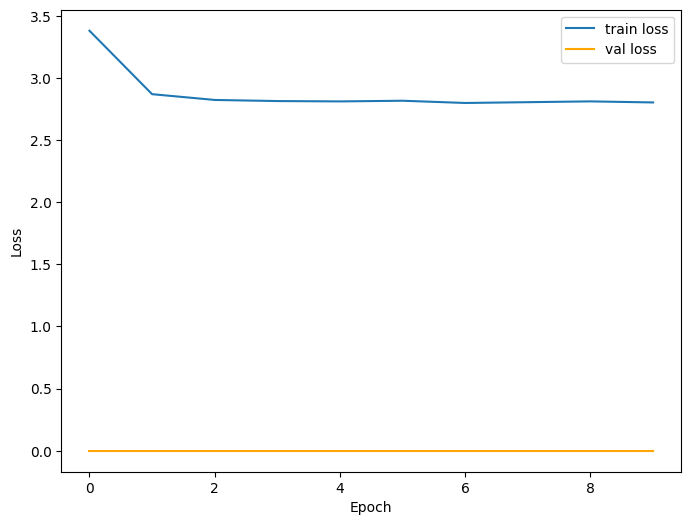

In [108]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

### Generating Text

In [109]:
class GenerateText:
    def __init__(self, model, k, int2char, char2int, device):
        self.int2char = int2char
        self.char2int = char2int
        self.n_chars = len(int2char)
        self.model = model
        self.device = device
        self.k = k
        self.sos_token = self.int2char[0]
        self.eos_token = self.int2char[1]
        
    def predict_next_char(self, hidden, input_char):
        
        # encode char
        char_one_hot = self.encode_char(input_char)

        # get the predictions
        with torch.no_grad():
            out, hidden = self.model(char_one_hot, hidden)
            
            # convert the output to a character probability distribution
            p = F.softmax(out, dim=1)

            # move to cpu as numpy doesn't support gpu
            p = p.cpu()

            # get top k characters from the distribution
            values, indices = p.topk(self.k)

        indices = indices.squeeze().numpy()
        values = values.squeeze().numpy()

        # sample any char from the top k chars using the output softmax distribution
        char_pred = np.random.choice(indices, size=1, p=values/values.sum())

        return self.int2char[char_pred[0]], hidden
    
    def generate_text(self, prime, max_chars=80):
        
        prime = self.sos_token + prime
        print(prime)

        all_chars = [char for char in prime]
        hidden = model.init_hidden(1, self.device)

        # build up the hidden state using the initial prime
        for char in prime:
            char_pred, hidden = self.predict_next_char(hidden, char)

        all_chars.append(char_pred)

        # generate n chars
        c = 0
        while char_pred != self.eos_token:
            if c == max_chars:
                break
            char_pred, hidden = self.predict_next_char(hidden, all_chars[-1])
            all_chars.append(char_pred)
            c += 1

        return "".join(all_chars)
        
    def encode_char(self, char):
        char_int = self.char2int[char]
        char_one_hot = F.one_hot(torch.tensor(char_int), self.n_chars).float()
        return char_one_hot.unsqueeze(0).unsqueeze(0).to(self.device)

In [110]:
k = 5

In [111]:
text_generator = GenerateText(model, k, train_dataset.int2char, train_dataset.char2int, device)

In [112]:
text_generator.generate_text('solid', max_chars=optimum_length)

[solid


'[solid eas   [[ [[[e[ e[[se[a [s[ [a[[[[[[ee[[[e[[a[[see[[  [s[  [eaea[e [[[es[[  [[[  aea[[ [[[ s[[ '